In [2]:
# GRU Forecasting - Traffic Volume

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set style 
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# 2. PREPARE DATA 
train = pd.read_csv("data_train.csv", parse_dates=['date_time'], index_col='date_time')
test = pd.read_csv("data_test.csv", parse_dates=['date_time'], index_col='date_time')

print(f"\nTrain: {train.index.min()} to {train.index.max()} ({len(train)} hours)")
print(f"Test:  {test.index.min()} to {test.index.max()} ({len(test)} hours)")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")



Train: 2012-03-12 14:00:00 to 2018-09-06 21:00:00 (15248 hours)
Test:  2018-09-06 22:00:00 to 2018-12-09 23:00:00 (720 hours)
Train shape: (15248, 70)
Test shape: (720, 70)


In [4]:
# 3. FEATURE SELECTION (Use same features as LSTM)
feature_cols = [
    'traffic_volume',    # Target (must be first column)
    
    # Weather features
    'temp_c',
    'rain_1h',
    'snow_1h',
    'clouds_all',
    
    # Time features
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos',
    
    # Lag features
    'traffic_lag_24',
    'traffic_lag_168',
    
    # Rolling statistics
    'traffic_rolling_mean_24',
    'traffic_rolling_std_24',
    
    # Holiday indicator
    'is_holiday'
]

# Filter to existing columns
feature_cols = [c for c in feature_cols if c in train.columns]

print(f"\nFeatures for GRU: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Extract feature matrices (same as LSTM)
train_data = train[feature_cols].values
test_data = test[feature_cols].values

print(f"\nTrain data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Features for GRU: 14
Features: ['traffic_volume', 'temp_c', 'rain_1h', 'snow_1h', 'clouds_all', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'traffic_lag_24', 'traffic_lag_168', 'traffic_rolling_mean_24', 'traffic_rolling_std_24', 'is_holiday']

Train data shape: (15248, 14)
Test data shape: (720, 14)


In [5]:
# 4. SCALING 
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

print(f"Train scaled shape: {train_scaled.shape}")
print(f"Test scaled shape: {test_scaled.shape}")
print(f"Scaled range: [{train_scaled.min():.3f}, {train_scaled.max():.3f}]")

# Save scaler (same as LSTM)
import joblib
joblib.dump(scaler, "gru_scaler.pkl")
print("\nScaler saved to 'gru_scaler.pkl'")


Train scaled shape: (15248, 14)
Test scaled shape: (720, 14)
Scaled range: [0.000, 1.000]

Scaler saved to 'gru_scaler.pkl'


In [6]:
# 5. CREATE SEQUENCES 
def create_sequences(data, window_size=24):
    """
    Create sequences for GRU input (same function as LSTM).
    
    Args:
        data: scaled data array
        window_size: lookback period (hours)
    
    Returns:
        X: sequences of shape (samples, window_size, features)
        y: targets of shape (samples,)
    """
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])  # All features
        y.append(data[i, 0])                 # Target (traffic_volume is col 0)
    return np.array(X), np.array(y)

# Define window size (same as LSTM: 24 hours)
WINDOW_SIZE = 24

# Create sequences (same as LSTM)
X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE)

n_features = X_train.shape[2]
print(f"\nNumber of features: {n_features}")
print(f"X_train shape: {X_train.shape}  (samples, timesteps, features)")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


Number of features: 14
X_train shape: (15224, 24, 14)  (samples, timesteps, features)
y_train shape: (15224,)
X_test shape:  (696, 24, 14)
y_test shape:  (696,)


In [7]:
# 6. BUILD GRU MODEL (Structure similar to LSTM)
model = Sequential([
    # First GRU layer (returns sequences for next GRU)
    GRU(128, return_sequences=True, input_shape=(WINDOW_SIZE, n_features)),
    Dropout(0.3),
    
    # Second GRU layer
    GRU(64, return_sequences=False),
    Dropout(0.3),
    
    # Dense layers 
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile model (same as LSTM)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print("\nGRU Model Architecture:")
model.summary()


GRU Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 128)        │        55,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,657 (369.75 KB)

 Trainable params: 94,657 (369.75 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 7. TRAIN MODEL (Same callbacks and parameters as LSTM)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

# Train model (same as LSTM)
print("\nTraining GRU model...")
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Training GRU model...
Epoch 1/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 39s 65ms/step - loss: 0.0304 - mae: 0.1302 - val_loss: 0.0142 - val_mae: 0.0926 - learning_rate: 0.0010
Epoch 2/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 35s 49ms/step - loss: 0.0155 - mae: 0.0932 - val_loss: 0.0051 - val_mae: 0.0556 - learning_rate: 0.0010
Epoch 3/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - loss: 0.0126 - mae: 0.0829 - val_loss: 0.0044 - val_mae: 0.0500 - learning_rate: 0.0010
Epoch 4/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.0110 - mae: 0.0773 - val_loss: 0.0040 - val_mae: 0.0472 - learning_rate: 0.0010
Epoch 5/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - loss: 0.0097 - mae: 0.0725 - val_loss: 0.0039 - val_mae: 0.0465 - learning_rate: 0.0010
Epoch 6/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - loss: 0.0088 - mae: 0.0691 - val_loss: 0.0030 - val_mae: 0.0405 - learning_rate: 0.0010
Epoch 7/50
429/429 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - loss: 0.0084 - mae: 0.0668 - val_loss: 0.0026 - val_mae: 

In [9]:
# 8. MAKE PREDICTIONS 
y_train_pred_scaled = model.predict(X_train, verbose=0).flatten()
y_test_pred_scaled = model.predict(X_test, verbose=0).flatten()

# Use LSTM's exact inverse transform function
def inverse_transform_target(scaler, scaled_values, feature_cols):
    """Inverse transform only the target variable (same as LSTM)"""
    n_features = len(feature_cols)
    dummy = np.zeros((len(scaled_values), n_features))
    dummy[:, 0] = scaled_values  # traffic_volume is first column
    
    inverse = scaler.inverse_transform(dummy)
    return inverse[:, 0]

# Inverse transform 
y_train_inv = inverse_transform_target(scaler, y_train, feature_cols)
y_test_inv = inverse_transform_target(scaler, y_test, feature_cols)
y_train_pred_inv = inverse_transform_target(scaler, y_train_pred_scaled, feature_cols)
y_test_pred_inv = inverse_transform_target(scaler, y_test_pred_scaled, feature_cols)

print(f"\nPredictions shape:")
print(f"  Train: {y_train_pred_inv.shape}")
print(f"  Test:  {y_test_pred_inv.shape}")



Predictions shape:
  Train: (15224,)
  Test:  (696,)


In [10]:
# 9. EVALUATE MODEL 
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
train_mae = mean_absolute_error(y_train_inv, y_train_pred_inv)
test_mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
train_r2 = r2_score(y_train_inv, y_train_pred_inv)
test_r2 = r2_score(y_test_inv, y_test_pred_inv)
overfitting_gap = train_r2 - test_r2 

print(f"\nGRU Model Performance:")
print(f"Train → RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}")
print(f"Test  → RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.4f}")

# Overfitting check 
print(f"\nOverfitting check: Train R² - Test R² = {overfitting_gap:.4f}")
if overfitting_gap > 0.10:
    print("Warning: Significant overfitting detected")
elif overfitting_gap > 0.05:
    print("Mild overfitting detected")
else:
    print("Model generalizes well")



GRU Model Performance:
Train → RMSE: 374.34, MAE: 235.75, R²: 0.9642
Test  → RMSE: 268.34, MAE: 196.25, R²: 0.9818

Overfitting check: Train R² - Test R² = -0.0176
Model generalizes well


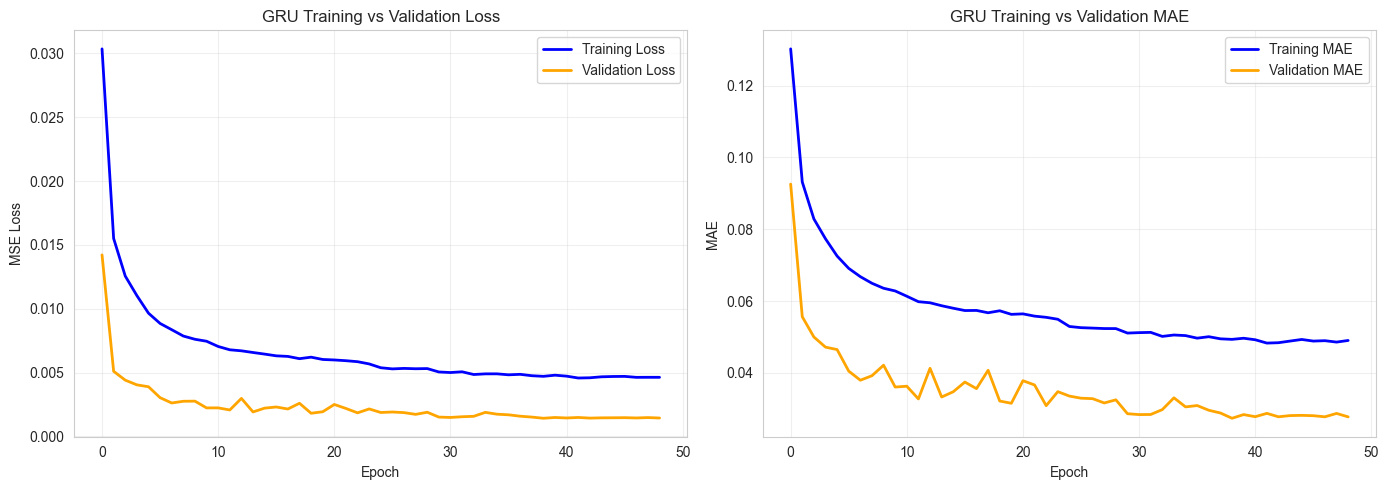

In [ ]:
# 10. TRAINING HISTORY VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('GRU Training vs Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# MAE curve
axes[1].plot(history.history['mae'], label='Training MAE', color='blue', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('GRU Training vs Validation MAE')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

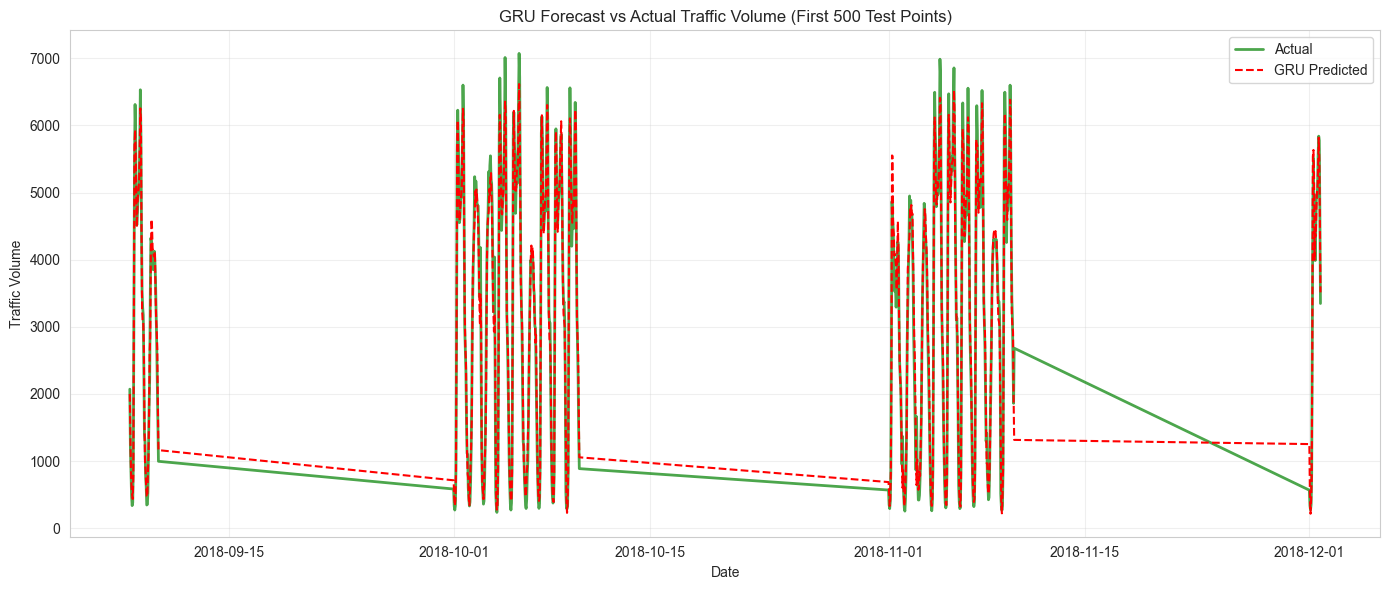

In [12]:
# 11. PREDICTIONS VISUALIZATION 
test_dates = test.index[WINDOW_SIZE:]
plot_points = min(500, len(y_test_inv))

plt.figure(figsize=(14, 6))
plt.plot(test_dates[:plot_points], y_test_inv[:plot_points], 
         label='Actual', color='green', linewidth=2, alpha=0.7)
plt.plot(test_dates[:plot_points], y_test_pred_inv[:plot_points], 
         label='GRU Predicted', color='red', linestyle='--', linewidth=1.5)
plt.title(f'GRU Forecast vs Actual Traffic Volume (First {plot_points} Test Points)')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

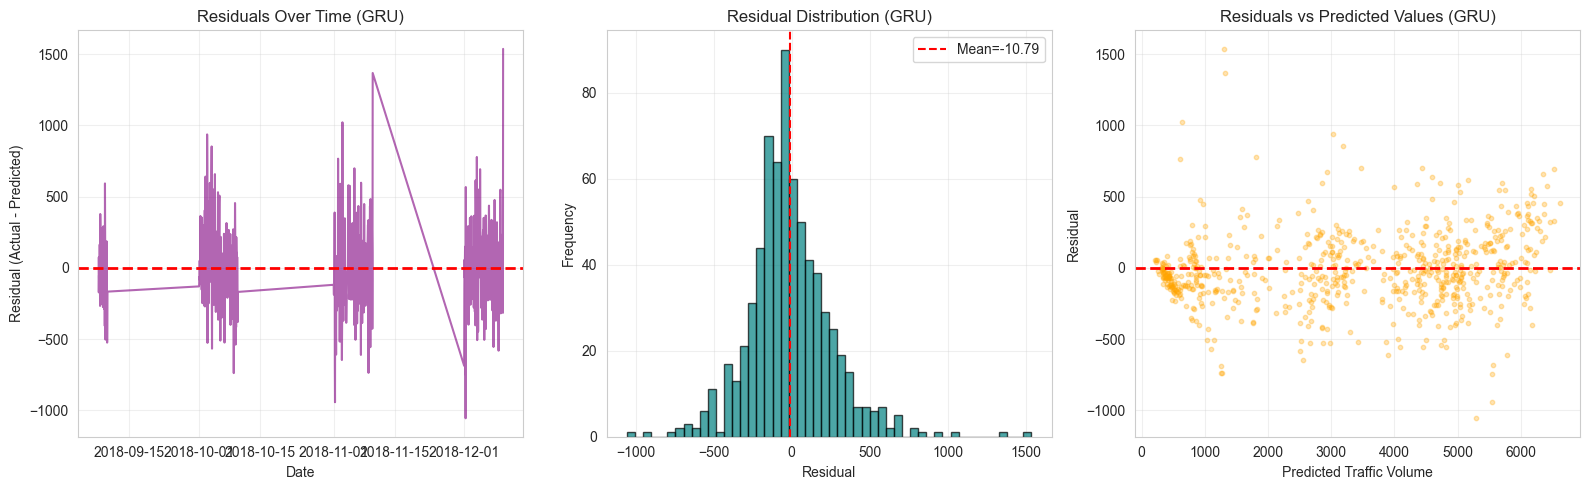


Residual Statistics:
count     696.000000
mean      -10.786291
std       268.314103
min     -1054.861726
25%      -159.083638
50%       -38.061644
75%       124.914172
max      1536.080009
dtype: float64


In [13]:
# 12. RESIDUAL ANALYSIS 
residuals = y_test_inv - y_test_pred_inv

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Residuals over time
axes[0].plot(test_dates, residuals, color='purple', alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Residuals Over Time (GRU)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Residual (Actual - Predicted)')
axes[0].grid(alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, color='teal', alpha=0.7, edgecolor='black')
axes[1].axvline(residuals.mean(), color='red', linestyle='--', 
                label=f'Mean={residuals.mean():.2f}')
axes[1].set_title('Residual Distribution (GRU)')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Residuals vs Predicted
axes[2].scatter(y_test_pred_inv, residuals, alpha=0.3, color='orange', s=10)
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Residuals vs Predicted Values (GRU)')
axes[2].set_xlabel('Predicted Traffic Volume')
axes[2].set_ylabel('Residual')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics 
print("\nResidual Statistics:")
print(pd.Series(residuals).describe())

In [14]:
# 13. NAIVE BASELINE COMPARISON 
if 'traffic_lag_168' in test.columns:
    naive_pred = test['traffic_lag_168'].values[WINDOW_SIZE:]
    valid_idx = ~np.isnan(naive_pred)
    naive_pred_clean = naive_pred[valid_idx]
    y_test_clean = y_test_inv[valid_idx]
    
    naive_rmse = np.sqrt(mean_squared_error(y_test_clean, naive_pred_clean))
    naive_mae = mean_absolute_error(y_test_clean, naive_pred_clean)
    naive_r2 = r2_score(y_test_clean, naive_pred_clean)
    
    print(f"\nNaive Seasonal Baseline (lag 168h):")
    print(f"  RMSE: {naive_rmse:.2f}")
    print(f"  MAE:  {naive_mae:.2f}")
    print(f"  R²:   {naive_r2:.4f}")
    
    print(f"\nGRU Improvement over Naive:")
    print(f"  RMSE reduction: {((naive_rmse - test_rmse) / naive_rmse * 100):.1f}%")
    print(f"  MAE reduction: {((naive_mae - test_mae) / naive_mae * 100):.1f}%")
else:
    print("\nWarning: traffic_lag_168 not available for naive baseline")



Naive Seasonal Baseline (lag 168h):
  RMSE: 1493.87
  MAE:  982.14
  R²:   0.4359

GRU Improvement over Naive:
  RMSE reduction: 82.0%
  MAE reduction: 80.0%


- important concept in time series forecasting
- The naive baseline establishes the **minimum performance threshold** any useful model must exceed. 
- It answers the fundamental question: **Does my complex model provide meaningful improvement over simple, intuitive approaches?**
so as to question whether the additional complexity is justified.

In [15]:
# 14. SAVE MODEL
model.save('gru_traffic_model.h5')
print("\nGRU Model saved to 'gru_traffic_model.h5'")

# Save metrics for comparison (same format as LSTM)
gru_results = pd.DataFrame([{
    'Model': 'GRU',
    'Window_Size': WINDOW_SIZE,
    'N_Features': n_features,
    'Total_Epochs': len(history.history['loss']),
    'Train_RMSE': train_rmse,
    'Test_RMSE': test_rmse,
    'Train_MAE': train_mae,
    'Test_MAE': test_mae,
    'Train_R2': train_r2,
    'Test_R2': test_r2,
    'Overfitting_Gap': overfitting_gap
}])

gru_results.to_csv('gru_results.csv', index=False)

print("\nGRU workflow completed")


GRU Model saved to 'gru_traffic_model.h5'

GRU workflow completed
